<a href="https://colab.research.google.com/github/akshitgoel48/EE5239-Nonlinear-Optimization/blob/master/WGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
# To generate GIFs
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
from tensorflow_gan.examples.mnist import util as eval_util

In [ ]:
# Loading the MNIST data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 50

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1,1]

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) 

In [ ]:
# Create the models

# Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256))) 
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model 

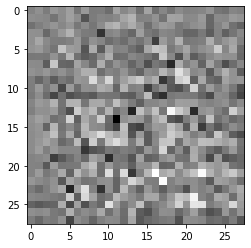

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [ ]:
# Discriminator model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model    

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [ ]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00075223]], shape=(1, 1), dtype=float32)


#For WGANs

> Loss function is defined as Wasserstein distance, 
$$W(P_r,P_\theta)=\sup_{\|f\|_L\leq1} \mathbb{E}_{x\sim \mathbb{P_r}}[f(x)]-\mathbb{E}_{x\sim \mathbb{P_\theta}}[f(x)]$$
If we have a parameterized family of functions $\{f_w\}_{w\in\mathcal{W}}$ that are all $K$-Lipschitz for some $K$, then we would solve- 
$$\max_{w\in \mathcal{W}}\;\;\mathbb{E}_{x\sim \mathbb{P_r}}[f_w(x)]-\mathbb{E}_{z\sim p(z)}[f_w(g_{\theta} (z))]$$
$$\Updownarrow$$
$$\min_{w\in \mathcal{W}}\;\;\mathbb{E}_{z\sim p(z)}[f_w(g_{\theta} (z))]-\mathbb{E}_{x\sim \mathbb{P_r}}[f_w(x)]$$
$\mathcal{W}$ is a compact space. For finding $f$ that solves the above max problem, we can train a neural network (NN) with parameters $w$. In order to have our weights $w$ lie in a compact space, we clamp the weights to a fixed box. For example, $\mathcal{W}=[-0.01, 0.01]^l$ after each gradient update.\
$f_w(x)$: critic function (a NN with parameters $w$). 
For our convenience, critic (in WGANs) = discriminator (in original GANs).\
$g_\theta (z)$: generator model (also a NN with parameters $\theta$).\
The problem with respect to the generator is-
$$\min_\theta\;\; -\mathbb{E}_{z\sim p(z)}[f_w(g_{\theta} (z))]$$



In [ ]:
# For WGANs
def discriminator_loss(real_output, fake_output):
    real_critic = tf.reduce_mean(real_output)
    fake_critic = tf.reduce_mean(fake_output)
    total_critic = fake_critic-real_critic
    return total_critic

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

Save checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#Training Loop

In [ ]:
EPOCHS = 15000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training step for WGANs

In [ ]:
# For WGANs
#@tf.function
def disc_train_step(images):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True) 
      fake_output = discriminator(generated_images, training=True)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    for l in discriminator.layers: # weight clipping
      weights = l.get_weights()
      weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
      l.set_weights(weights)

    return disc_loss       

def gen_train_step():
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss
    

In [ ]:
def generate_and_save_images(model, epoch, predictions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def inf_train_gen():
    while True:
        for images in train_dataset:
            yield images

def train(epochs):
  generated_mnist_score = []
  wgan_disc_loss = []
  wgan_gen_loss  = []

  
  generated_data = generator(seed, training=False)
  generated_mnist_score = np.append(generated_mnist_score, eval_util.mnist_score(generated_data))

  it = inf_train_gen()
  fake_data = generator(tf.random.normal([BATCH_SIZE, noise_dim]), training=False)
  wgan_disc_loss = np.append(wgan_disc_loss, discriminator_loss(next(it), fake_data))
  wgan_gen_loss = np.append(wgan_gen_loss, generator_loss(fake_data))

  it = inf_train_gen()
  for epoch in range(epochs):
    start = time.time()

    for critic_iters in range(5):
      image_batch = next(it)
      loss1 = disc_train_step(image_batch)
    loss2 = gen_train_step() 

    # Produce images for the GIF as we go
    if (epoch+1) % 50 == 0:
      wgan_disc_loss = np.append(wgan_disc_loss, loss1)
      wgan_gen_loss = np.append(wgan_gen_loss, loss2)  
      generated_data = generator(seed, training=False)
      generated_mnist_score = np.append(generated_mnist_score, eval_util.mnist_score(generated_data))

    if (epoch+1) % 200 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch + 1, generated_data)
      checkpoint.save(file_prefix = checkpoint_prefix) # Save the model every 200 epochs
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, generated_data)
  return generated_mnist_score, wgan_disc_loss, wgan_gen_loss

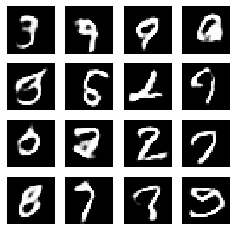

In [ ]:
[wgan_score, LOSS1, LOSS2] = train(EPOCHS)

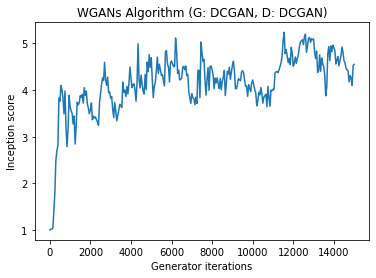

In [ ]:
plt.plot(range(0,EPOCHS+1,50), wgan_score)
plt.xlabel('Generator iterations')
plt.ylabel('Inception score')
plt.title('WGANs Algorithm (G: DCGAN, D: DCGAN)')
plt.savefig('wgan_icp.png')

In [ ]:
np.save('WGAN_score',wgan_score)

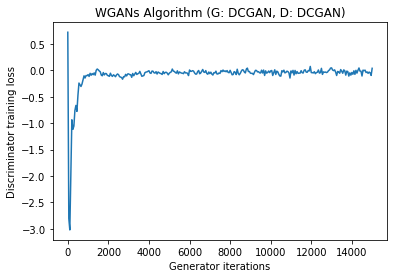

In [ ]:
plt.plot(range(0,EPOCHS+1,50),LOSS1)
plt.xlabel('Generator iterations')
plt.ylabel('Discriminator training loss')
plt.title('WGANs Algorithm (G: DCGAN, D: DCGAN)')
plt.savefig('wgan_disc_loss.png')

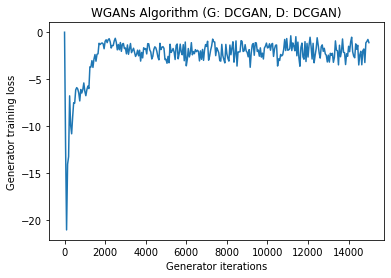

In [ ]:
plt.plot(range(0,EPOCHS+1,50),LOSS2)
plt.xlabel('Generator iterations')
plt.ylabel('Generator training loss')
plt.title('WGANs Algorithm (G: DCGAN, D: DCGAN)')
plt.savefig('wgan_gen_loss.png')

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)